# **Loan Eligibility Prediction**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Loading all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Reading the data

In [130]:
#Importing the training data
train = pd.read_csv('Aequitas-Final.csv')
train=train.drop('field1', axis=1)
train.head(5)

,Gender_Male,Married,Dependents,Graduate,Self_Employed,Credit_History,Property_Area,Actual,Prediction
0,Male,No,0,Graduate,No,1.0,Urban,Y,Y
1,Male,Yes,1,Graduate,No,1.0,Rural,N,N
2,Male,Yes,0,Graduate,Yes,1.0,Urban,Y,Y
3,Male,Yes,0,Not Graduate,No,1.0,Urban,Y,Y
4,Male,No,0,Graduate,No,1.0,Urban,Y,Y


**Data needs to be preprocessed for compatibility with Aequitas. Aequitas tool always requires a `score` column and requires a binary `label_value` column.**

In [131]:
#Data needs to be preprocsssed before using Aequitas. Only dependant variables can be int, and others have to be objects
train = train.replace({'Actual':{'Y':1,'N':0}})
train = train.replace({'Prediction':{'Y':1,'N':0}})
train = train.replace({'Credit_History':{1:'Yes',0:'No'}})

In [ ]:
train.dtypes

In [132]:
#These are the argument names in the library for actual and predicted columns
train = train.rename(columns = {'Prediction':'score'})
train = train.rename(columns = {'Actual':'label_value'})

In [133]:
#for understanding
train = train.rename(columns={'Gender_Male':'Gender','Graduate':'Education', 'Property_Area':'Property'})

In [134]:
train.head(5)

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property,label_value,score
0,Male,No,0,Graduate,No,Yes,Urban,1,1
1,Male,Yes,1,Graduate,No,Yes,Rural,0,0
2,Male,Yes,0,Graduate,Yes,Yes,Urban,1,1
3,Male,Yes,0,Not Graduate,No,Yes,Urban,1,1
4,Male,No,0,Graduate,No,Yes,Urban,1,1


In [ ]:
#Save the pre-processed dataset as new file
#train.to_csv('Aequitas_Final.csv')

In [135]:
#Let us ony check biases across Gender, Marital status, and Education
df = train[['Gender','Married','Education','label_value','score']]

In [136]:
#Save the pre-processed dataset as new file
df.to_csv('Aequitas_Final.csv')

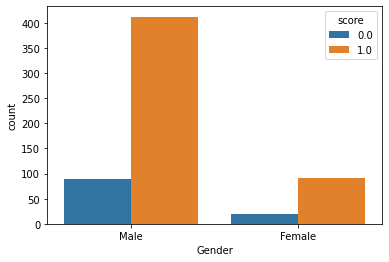

In [50]:
#Data Exploration
gender = sns.countplot(x="Gender", hue="score", data=df)

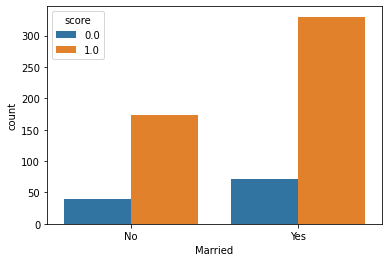

In [51]:
marriage = sns.countplot(x='Married', hue='score', data=df)

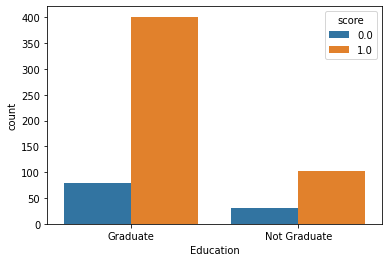

In [52]:
cred = sns.countplot(x='Education', hue='score', data=df)

We will apply Aequitas in a two step process:

`Group()`: Define groups 

`Bias()`: Calculate disparities



In [83]:
#install required libraries

!pip install aequitas
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

**The** `get_crosstabs()` **method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate , false negative rate, etc.**

In [53]:
g = Group()
xtab, _ = g.get_crosstabs(df)

In [54]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [55]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,504,Gender,Female,92,20,19,2,18,73,75,37,112,614
1,0,binary 0/1,504,Gender,Male,412,90,77,12,78,335,347,155,502,614
2,0,binary 0/1,504,Married,No,174,39,45,5,34,129,134,79,213,614
3,0,binary 0/1,504,Married,Yes,330,71,51,9,62,279,288,113,401,614
4,0,binary 0/1,504,Education,Graduate,401,79,73,12,67,328,340,140,480,614
5,0,binary 0/1,504,Education,Not Graduate,103,31,23,2,29,80,82,52,134,614


In [56]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(3)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,Gender,Female,0.973,0.486,0.100,0.207,0.514,0.027,0.900,0.793,0.183,0.821,0.670
1,Gender,Male,0.965,0.503,0.133,0.187,0.497,0.035,0.867,0.813,0.817,0.821,0.691
2,Married,No,0.963,0.430,0.128,0.259,0.570,0.037,0.872,0.741,0.345,0.817,0.629
3,Married,Yes,0.969,0.549,0.127,0.155,0.451,0.031,0.873,0.845,0.655,0.823,0.718
4,Education,Graduate,0.965,0.479,0.152,0.182,0.521,0.035,0.848,0.818,0.796,0.835,0.708
5,Education,Not Graduate,0.976,0.558,0.065,0.223,0.442,0.024,0.935,0.777,0.204,0.769,0.612


false discovery rate (fdr) = false positives (fp) / predicted positives (pp)

## How to interpret bias from the table above?

We see that `Female` have a false positive rate (fpr) of **51%**, while `Male` have a false positive rate of **49%**. This means that females are more likely to be falsely labeled as eligible than males. Which means that more females would get loans. (there is not much bias with regards to gender in this dataset)

**OR**

`Female` have a false negative rate (fnr) of **2.7%**, while `Male` have a false negative rate of **3.5%**. This means that males are more likely to be falsely labeled as not eligible for loan than females. 

Also, we can see that the `fnr` for married people is **3.1%** compared to those not married which is **3.7%**. This means that if you are not married, you are more likely to be falsely labeled as not eligible for loan by the model.

And, the `fnr` for graduate people is **3.5%** compared to non-graduates which is **2.4%**. This means that if you are a graduate, you are more likely to be falsely labeled as not eligible for loan by the model. (weird)

### So we can conclude that this model is in favour of females, married people, and non-graduates.

##Visualizations

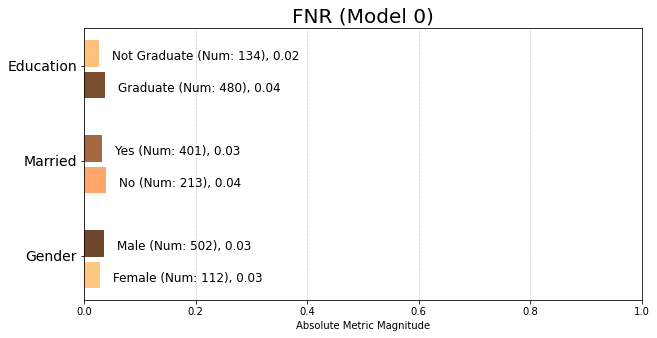

In [87]:
#Visualize the above conclusion. The dark colour indicates high fnr
fnr = Plot().plot_group_metric(xtab, 'fnr')

it's possible to efficiently find thresholds that meet any of these criteria. In other words, even if you don't have control over the underlying scoring system (a common case) it's still possible to attack the issue of discrimination.

https://research.google.com/bigpicture/attacking-discrimination-in-ml/

# Calculate disparity between Groups

Disparities are calculated as a ratio of a metric for a group of interest compared to a reference group. 

For example, the False Positive Rate Disparity for female vs male is 0.514/0.497 = 1.02

Below, we will use `get_disparity_predefined_groups()` method that allows us to define a base group for each attribute.

In [29]:
b = Bias()

In [57]:
#Disparities calculated in reference to a user-specified group for each attribute
dp = b.get_disparity_predefined_groups(xtab, original_df=df,
                                        ref_groups_dict={'Gender':'Female', 'Married':'Yes', 'Education':'Not Graduate'},
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)


get_disparity_predefined_group()


In [58]:
# View disparity metrics added to dataframe
dp[['attribute_name', 'attribute_value'] + b.list_disparities(dp) + b.list_significance(dp)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,Gender,Female,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
1,Gender,Male,0.904957,1.296830,1.333333,0.967402,0.962963,4.478261,0.999134,1.024737,1.034409,0.991868,False,False,False,False,False,False,False,False,False,False,False,False
2,Married,No,1.673428,1.194030,1.011396,1.262100,0.998346,0.527273,0.992659,0.876900,0.784402,0.993741,True,False,True,False,False,True,False,False,False,True,True,False
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
4,Education,Graduate,0.815244,1.447059,2.354430,1.178882,0.906591,3.893204,1.086853,1.053117,0.858128,0.988824,True,False,False,False,False,False,False,False,False,False,False,False
5,Education,Not Graduate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False



The Aequitas `Bias()` class includes get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and vice versa.

Using the `get_disparity_major_group()` method of calculation allows us to quickly evaluate how much more or less other groups are falsely or correctly identified in reference to the group that we have the most data on.
 

## How to read disparity?

###Looking at the `fnr` disparity ratio, males are falsely identified as not being eligible for loan **1.29** times the rate of females.

By default, all the reference groups will have a disparity 1 in Aequitas

##Visualize disparities between groups

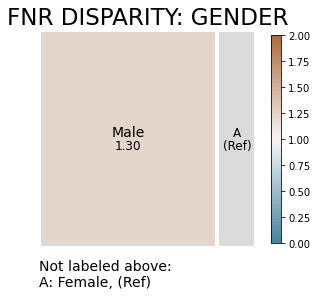

In [90]:
Plot().plot_disparity(dp, group_metric='fnr_disparity', attribute_name='Gender', significance_alpha=0.05)


#Visualizations

In [186]:
metrics = ['fnr','for']


Fairness threshold is the **diparity tolerance** of the organization.

In [187]:
ap.summary(dp, metrics, fairness_threshold = 1.2)


alt.VConcatChart(...)

In [171]:
ap.disparity(dp, metrics, 'Gender', fairness_threshold = 1.2)

alt.LayerChart(...)

For this example you have to do false negatives

In [172]:
ap.disparity(dp, metrics, 'Married', fairness_threshold = 1.2)

alt.LayerChart(...)

### Assistive vs Punitive intervention
Assistive - use FNR
Punitive - use FPR


In [ ]:
#@title Generate Bias Report

from datetime import datetime
print('Audit Date:', datetime.today().strftime('%Y-%m-%d'))
print('\n\nData:', df.shape[0],'rows')
print('\n\nReference Groups:', 'Gender: Female,', 'Married: Yes,', 'Education: Not Graduate')
print('\n\nFairness Threshold:', 'If disparity for a group is within 80% and 125% (0.8 < Disparity < 1.25) of the value of the reference group, this audit will pass.')

print('\n\nMetrics Audited: \n\n','1. False Negative Rate (fnr) \n'

'2. False Ommision Rate (for) \n'

)

ap.summary(dp, metrics, fairness_threshold = 1.2)

In [199]:
#dp

# Fairness Tree

https://github.com/dssg/aequitas

**1. Equal Parity (ppr_disparity)** - all protected groups are have equal representation in the selected set. 
If the ppr_disparity of each group is within the range allowed by the fairness_threhold value it passes.

**2. Proportional Parity (pprev_disparity)** - all protected groups are selected proportional to their percentage of the population.
If the pprev_disparity of each group is within the range allowed by the fairness_threhold value it passes.

**3. False Positive Rate Parity (fpr_disparity)** - all protected groups have the same false positive rates as the reference group.
If the fpr_disparity of each group is within the range allowed by the fairness_threhold value it passes.

**4. False Negative Rate Parity (fnr_disparity)** - all protected groups have the same false negative rates as the reference group.
If the fnr_disparity of each group is within the range allowed by the fairness_threhold value it passes.

**5. False Discovery Rate Parity (fdr_disparity)** - all protected groups have equally proportional false positives within the selected set (compared to the reference group)
If the fdr_disparity of each group is within the range allowed by the fairness_threhold value it passes.

`false discovery rate (fdr) = false positives (fp) / predicted positives (pp)`


**6. False Ommision Rate Parity (for_disparity)** - all protected groups have equally proportional false negatives within the non-selected set (compared to the reference group)
If the for_disparity of each group is within the range allowed by the fairness_threhold value it passes.

`false ommision rate (for) = false negatives (fn) / predicted negatives (pn)`

## Fairness Tree


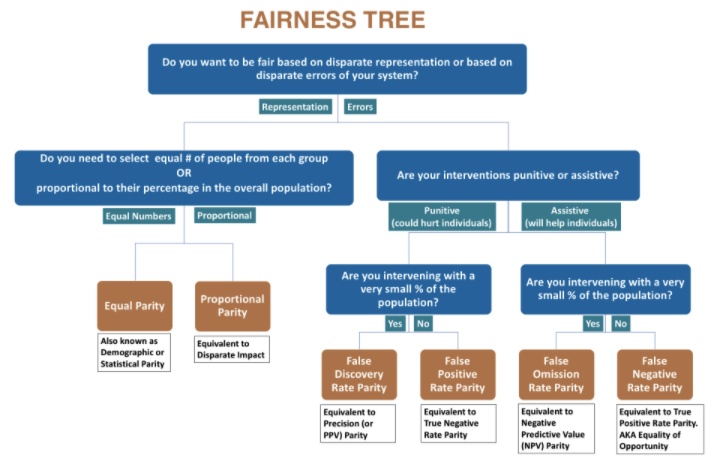

## Equal Parity

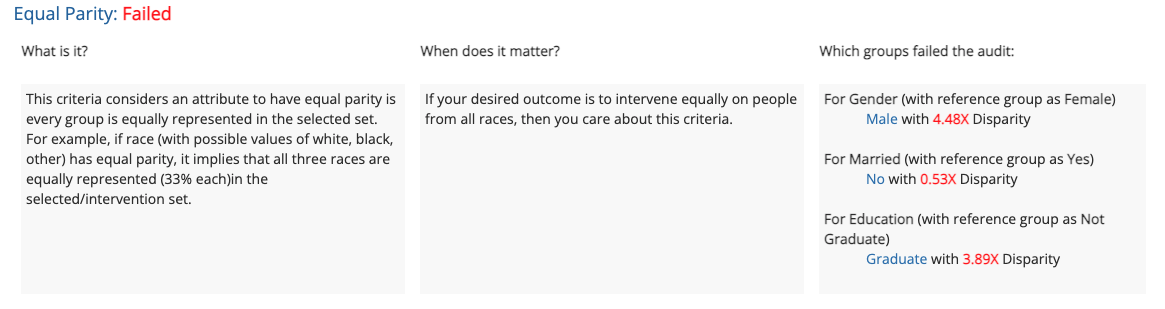

## Proportional Parity

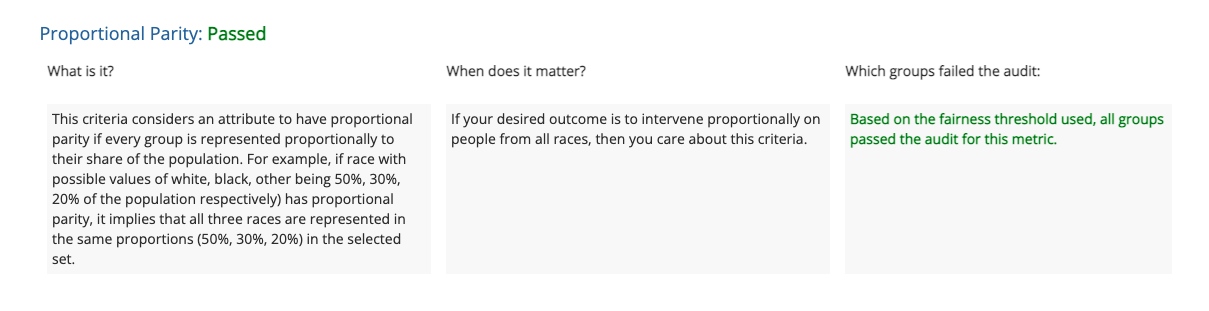

## False Positive Rate Parity

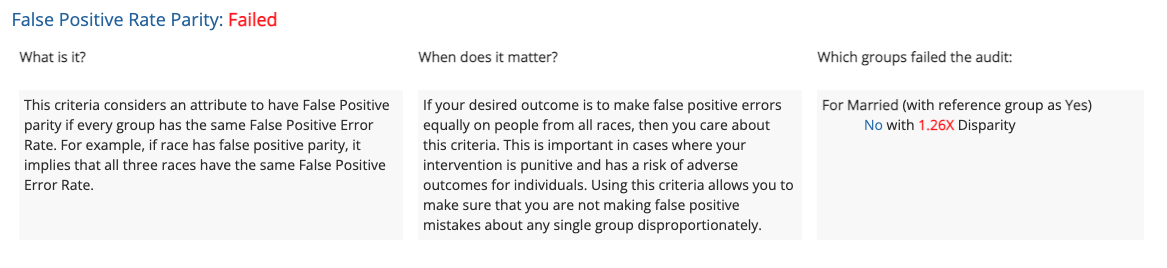

## False Negative Rate Parity

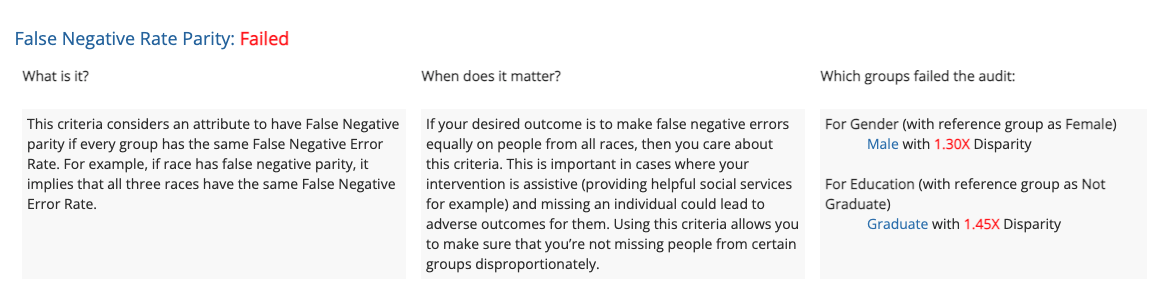

## False Discovery Rate Parity

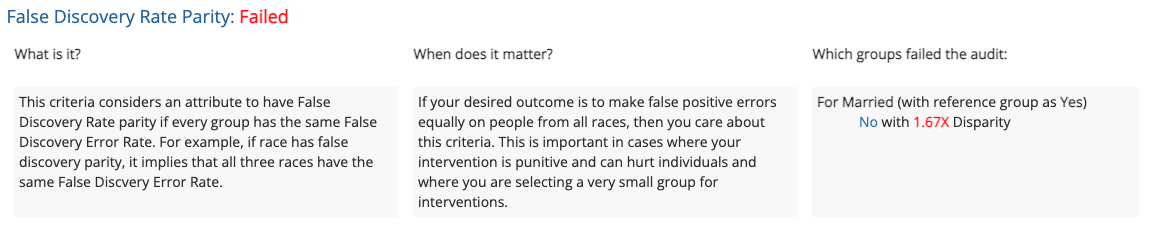

## False Omission Rate Parity

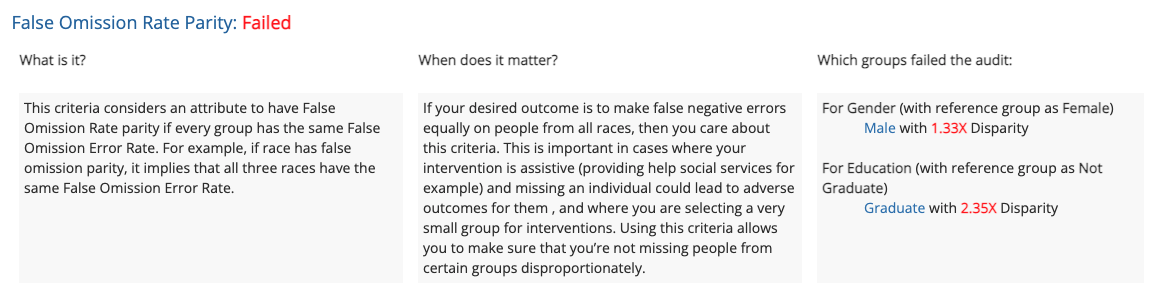

Audit Date & Time: 2021-11-15 21:38:26


Data Audited: 614 rows


Reference Groups: Gender: Female, Married: Yes, Education: Not Graduate


Fairness Threshold: If disparity for a group is within 80% and 125% (0.8 < Disparity < 1.25) of the value of the reference group, this audit will pass.


Metrics Audited: 

 1. False Negative Rate (fnr) 
2. False Ommision Rate (for) 



alt.VConcatChart(...)